In [1]:
!pip install .
!pip install pandas scikit-learn tensorboard

Processing /Users/tom/Desktop/temp_folder_trasnsfer/TorchGRTL
  Preparing metadata (setup.py) ... done
  Created wheel for GeneralRelativity: filename=GeneralRelativity-0.1-py3-none-any.whl size=3275 sha256=4d87151ba318d900e51079eba82c86c5a0690db77c7e92c83422b0d7b9cacf44
  Stored in directory: /private/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/pip-ephem-wheel-cache-84s2m0tk/wheels/4a/14/b4/9ad481489b414caef94a9ad5da3310a1c3acfbd67da647d64b
Successfully built GeneralRelativity
  Attempting uninstall: GeneralRelativity
    Found existing installation: GeneralRelativity 0.1
    Uninstalling GeneralRelativity-0.1:
      Successfully uninstalled GeneralRelativity-0.1


In [2]:
import torch
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import r2_score
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

%reload_ext tensorboard
from GeneralRelativity.Utils import (
    get_box_format,
    TensorDict,
    cut_ghosts,
    keys,
    keys_all,
)
from GeneralRelativity.DimensionDefinitions import FOR1, FOR2, FOR3, FOR4
from GeneralRelativity.FourthOrderDerivatives import diff1, diff2
from GeneralRelativity.TensorAlgebra import (
    compute_christoffel,
    compute_trace,
    compute_christoffel_fast,
    raise_all,
)
from GeneralRelativity.CCZ4Geometry import compute_ricci
from GeneralRelativity.Constraints import constraint_equations

from torch.utils.data import TensorDataset, DataLoader

time_stamp = int(time.time())

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Executing the model on :", device)

torch.manual_seed(1)
np.random.seed(4)
writer = SummaryWriter()

Executing the model on : cpu


In [4]:
# Loading small testdata
filenamesX = "tests/TestData/Xdata_level0_step*"
num_varsX = 104
dataX = get_box_format(filenamesX, num_varsX)
# Cutting out extra values added for validation
dataX = dataX[:, :, :, :, :25]

Loading data


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
# A small default model
class SuperResolution3DNet(torch.nn.Module):
    def __init__(self):
        super(SuperResolution3DNet, self).__init__()

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv3d(25, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(64, 25, kernel_size=3, padding=1),
        )

    def forward(self, x):
        tmp = x
        x = self.encoder(x)
        x = self.decoder(x)
        # Reusing the input data for faster learning
        x[:, :, ::2, ::2, ::2] = tmp[:, :, ...]
        return x


# Instantiate the model
net = SuperResolution3DNet().to(torch.double)

In [18]:
# global step counter
counter = 0

losses_train = []
losses_val = []

In [19]:
# Create a random 3D low-resolution input tensor (batch size, channels, depth, height, width)
input_tensor = torch.randn(1, 25, 32, 32, 32)  # Adjust dimensions as needed

# Instantiate the model
model = SuperResolution3DNet()

# Forward pass to obtain the high-resolution output
output_tensor = model(input_tensor)

# Check the shape of the output
print("Input Shape:", input_tensor.shape)
print("Output Shape:", output_tensor.shape)

Input Shape: torch.Size([1, 25, 32, 32, 32])
Output Shape: torch.Size([1, 25, 64, 64, 64])


In [20]:
optimizerBFGS = torch.optim.LBFGS(
    net.parameters(), lr=0.1
)  # Use LBFGS sometimes, it really does do magic sometimes, though its a bit of a diva
optimizerADAM = torch.optim.Adam(net.parameters(), lr=0.0001)

In [21]:
# Define the ratio for the split (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
num_samples = len(dataX)
num_train = int(train_ratio * num_samples)
num_test = num_samples - num_train

train_torch = dataX[:num_train].permute(0, 4, 1, 2, 3).to(device)
test_torch = dataX[num_train:].permute(0, 4, 1, 2, 3).to(device)

# Create DataLoader for batching -- in case data gets larger
# train_loader = DataLoader(dataset=TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
# test_loader = DataLoader(dataset=TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size, shuffle=False, num_workers=0)  # Batch size for test can be larger if you have the memory

In [22]:
# Magical loss coming from General Relativity
class Hamiltonian_loss:
    def __init__(self, oneoverdx: float):
        self.oneoverdx = oneoverdx

    def __call__(self, output: torch.tensor, dummy: torch.tensor) -> torch.tensor:
        # For learning we need shape (batch,channel,x,y,z), however TorchGRTL works with (batch,x,y,z,channel), thus the permute
        output = output.permute(0, 2, 3, 4, 1)
        # cutting ghosts off, otherwise you will run into problems later
        dataXcut = cut_ghosts(output)

        # creating dict with values
        vars = TensorDict(dataXcut, keys)
        # creating dict with derivatives
        d1 = TensorDict(diff1(output, oneoverdx), keys)
        d2 = TensorDict(diff2(output, oneoverdx**2), keys)
        # calculating variables required for constraints
        h_UU = torch.inverse(vars["h"])
        chris = compute_christoffel(d1["h"], h_UU)
        # Computing Constraints
        out = constraint_equations(vars, d1, d2, h_UU, chris)
        loss = torch.mean(out["Ham"] * out["Ham"])
        return loss


oneoverdx = 64.0 / 4.0
my_loss = Hamiltonian_loss(oneoverdx)

In [23]:
# load model in case you restart form checkpoint
restart = False
file_path = "model.pth"
if restart and os.path.exists(file_path):
    net.load_state_dict(torch.load(file_path))

  0%|          | 0/10 [00:00<?, ?it/s]

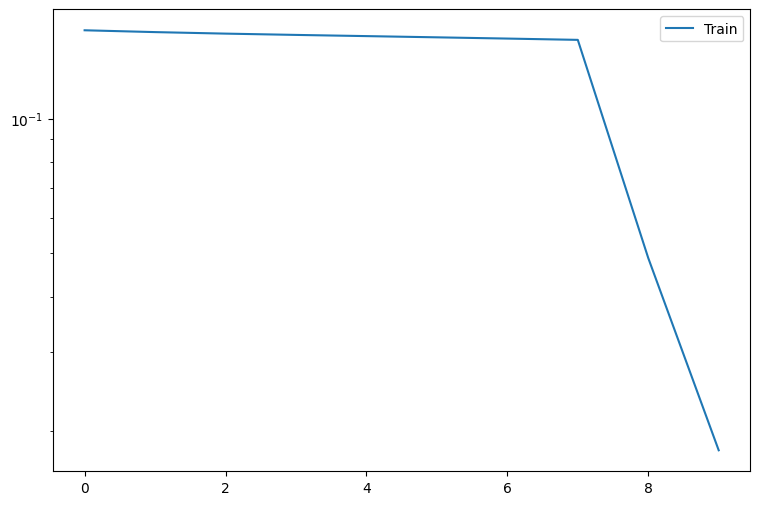

In [24]:
# Note: it will slow down signficantly with BFGS steps, they are 10x slower, just be aware!
ADAMsteps = 8  # Will perform # steps of ADAM steps and then switch over to BFGS-L
n_steps = 10  # Total amount of steps

net.train()
net.to(device)

my_loss = torch.nn.L1Loss()

pbar = trange(n_steps)
for i in pbar:
    batchcounter = 0
    # for X_batch, y_batch in train_loader:
    y_batch = train_torch.to(device)
    X_batch = y_batch[:, :, ::2, ::2, ::2].clone()
    y_batch = y_batch[:, :25]

    batchcounter += 1

    # This is needed for LBFGS
    def closure():
        if torch.is_grad_enabled():
            optimizerBFGS.zero_grad()
        y_pred = net(X_batch)

        loss_train = my_loss(y_pred, y_batch)
        if loss_train.requires_grad:
            loss_train.backward()
        return loss_train

    # doing some ADAM first to warm up, sometimes BFGS fuckes up if you start too early
    if counter < ADAMsteps:
        y_pred = net(X_batch)

        loss_train = my_loss(y_pred, y_batch)
        optimizerADAM.zero_grad()
        loss_train.backward()
        optimizerADAM.step()
        # print(f'ADAM {batchcounter}')

    else:
        optimizerBFGS.step(closure)
        # print(f'BFGS {batchcounter}')

    output = net(X_batch)
    loss_train = closure()
    writer.add_scalar("loss/train", loss_train.item(), i)
    losses_train.append(loss_train.item())
    if np.isnan(loss_train.item()):
        print("we got nans")
    # print(loss_train.item())
    # Advancing global counter
    counter += 1
    # Validation

    if counter % 1 == 0:
        with torch.no_grad():
            # for X_val_batch, y_val_batch in test_loader:
            # Transfer batch to GPU
            y_val_batch = test_torch.to(device)
            X_val_batch = y_val_batch[:, :, ::2, ::2, ::2].clone()
            y_val_batch = y_val_batch[:, :25]
            y_val_pred = net(X_val_batch)
            loss_val = my_loss(y_val_pred, y_val_batch)
            losses_val.append(loss_val.item())
            writer.add_scalar("loss/test", loss_val.item(), i)
    if counter % 1000 == 0:
        # Writing out network and scaler
        torch.save(
            net.state_dict(),
            f"model_epoch_counter_{counter:010d}_data_time_{time_stamp}.pth",
        )


# Plotting shit at the end
plt.figure(figsize=(9, 6))
plt.plot(np.array(losses_train), label="Train")
# plt.plot(np.array(losses_val), label="Val with Relative loss", linewidth=0.5)
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

writer.flush()
writer.close()

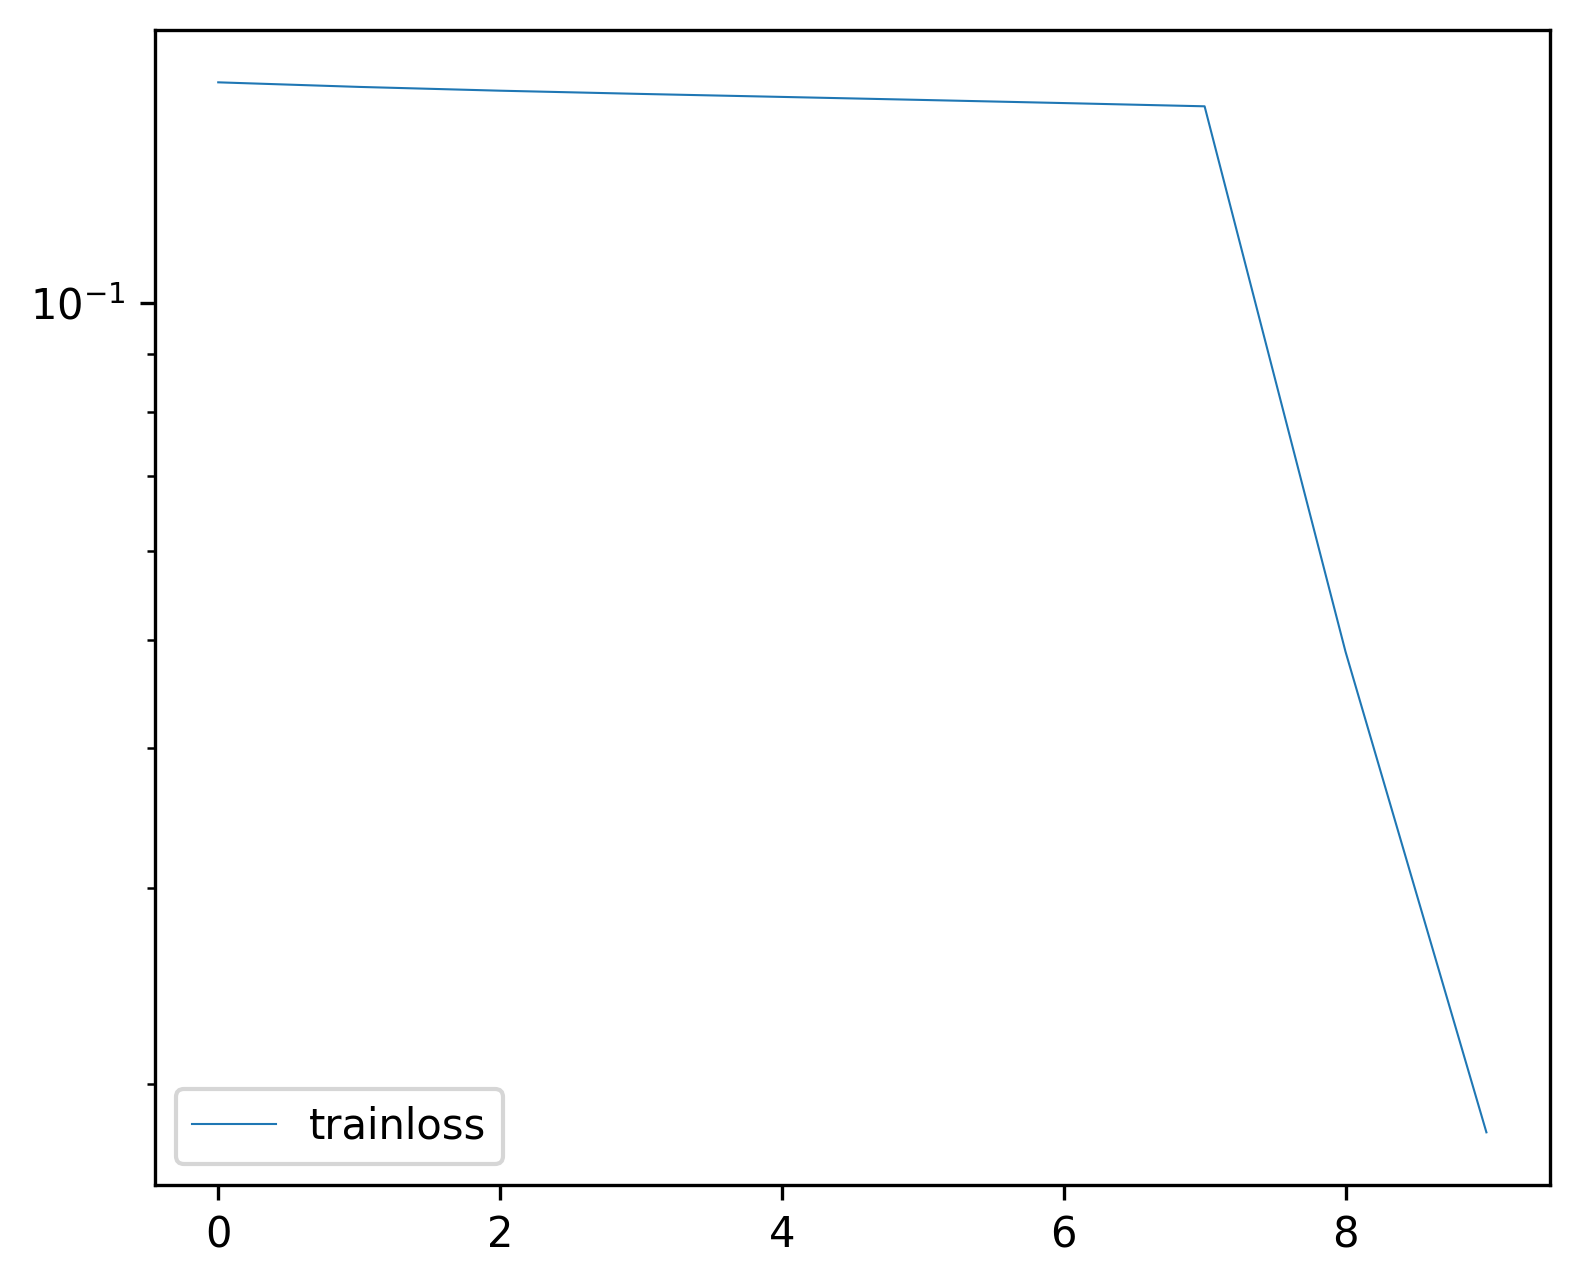

In [25]:
plt.figure(figsize=(6, 5), dpi=300)

plt.plot(np.array(losses_train), label="trainloss", linewidth=0.5)
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

writer.flush()
writer.close()

In [44]:
# Get comparison with classical methods
from GeneralRelativity.Interpolation import *

# Interpolation compared to what is used typically in codes ( we interpolate between 6 values with polynomials x^i y^k z^k containing powers up to 3)
points = 6
power = 3
shape = X_batch.shape
interpolation = interp(points, power,False)
ghosts = int(math.ceil(points / 2))
shape_higher_order = (shape[-1] - 2 * ghosts) * 2 + 2

y_interpolated, _ = interpolation(X_batch)
y_interpolated_buffer = torch.zeros_like(y_batch)
diff = (y_batch.shape[-1] - y_interpolated.shape[-1]) // 2
y_interpolated_buffer[:, :, diff:-diff, diff:-diff, diff:-diff] = y_interpolated

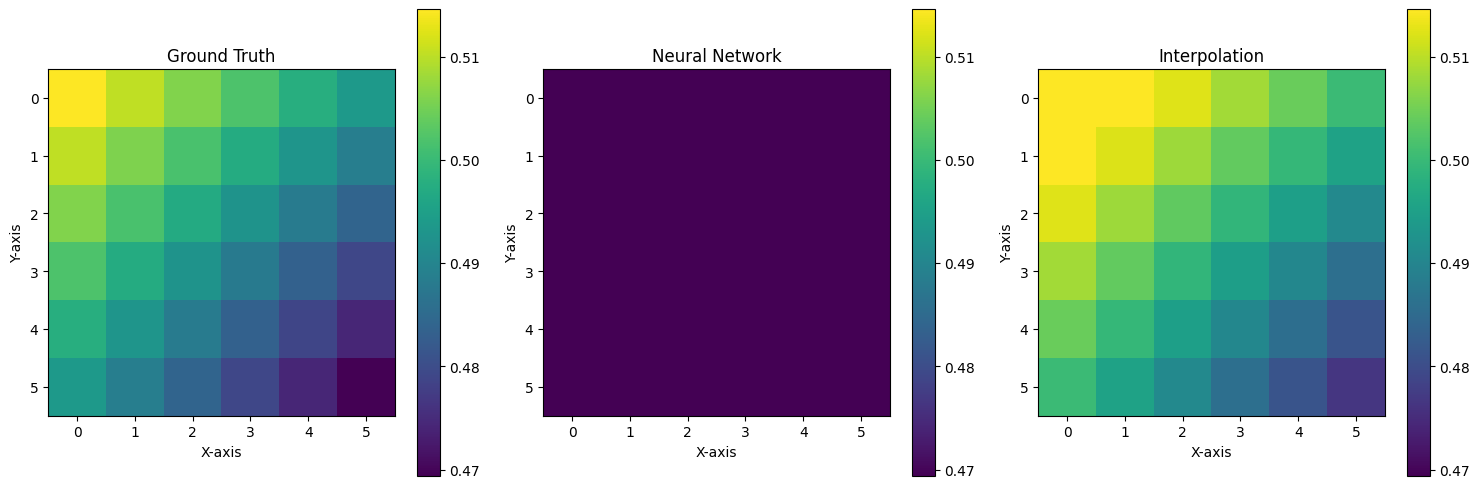

In [45]:
box = 0
channel = 0
slice = 9
# Note we remove some part of the grid as the interpolation needs space
max_val = torch.max(y_batch[box, channel, diff:-diff, diff:-diff, slice]).numpy()
min_val = torch.min(y_batch[box, channel, diff:-diff, diff:-diff, slice]).numpy()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot ground truth
axes[0].set_title("Ground Truth")
im0 = axes[0].imshow(y_batch[box, channel, diff:-diff, diff:-diff, slice].numpy(), vmin=min_val, vmax=max_val, cmap='viridis')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

# Plot Neural Network
axes[1].set_title("Neural Network")
im1 = axes[1].imshow(y_pred[box, channel, diff:-diff, diff:-diff, slice].detach().numpy(), vmin=min_val, vmax=max_val, cmap='viridis')
axes[1].set_xlabel('X-axis')
axes[1].set_ylabel('Y-axis')

# Plot Interpolation
axes[2].set_title("Interpolation")
im2 = axes[2].imshow(y_interpolated[box, channel, :, :, slice - diff], vmin=min_val, vmax=max_val, cmap='viridis')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Y-axis')

# Add colorbars
cbar0 = fig.colorbar(im0, ax=axes[0])
#cbar0.set_label('Values')
cbar1 = fig.colorbar(im1, ax=axes[1])
#cbar1.set_label('Values')
cbar2 = fig.colorbar(im2, ax=axes[2])
#cbar2.set_label('Values')
plt.tight_layout()
plt.show()

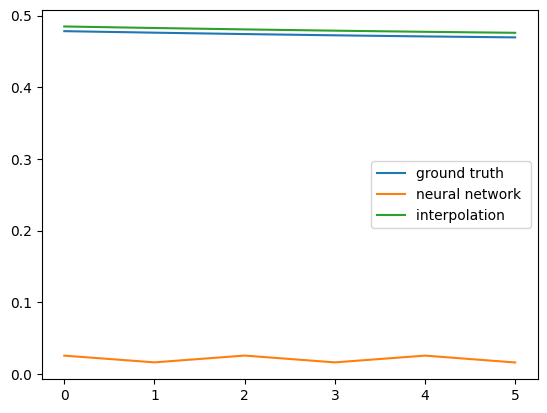

In [46]:
box = 5
channel = 0
slice = 5
plt.plot(
    y_batch[box, channel, diff:-diff, slice, slice].detach().cpu().numpy(),
    label="ground truth",
)
plt.plot(
    y_pred[box, channel, diff:-diff, slice, slice].detach().cpu().numpy(),
    label="neural network ",
)
plt.plot(
    y_interpolated_buffer[box, channel, diff:-diff, slice, slice]
    .detach()
    .cpu()
    .numpy(),
    label="interpolation ",
)
plt.legend()
plt.show()

In [47]:
# Calculate L2Ham performance
my_loss = Hamiltonian_loss(oneoverdx)
print(
    f"Reference data L2 {my_loss(y_batch[:, :, diff:-diff, diff:-diff, diff:-diff], torch.tensor([])).detach().numpy()}"
)
print(
    f"Neural Network L2 loss {my_loss(y_pred[:, :, diff:-diff, diff:-diff, diff:-diff], torch.tensor([])).detach().numpy()}"
)
print(f"Interpolation {my_loss(y_interpolated, torch.tensor([])).detach().numpy()}")

Reference data L2 1.0373636182292944e-14
Neural Network L2 loss 58302717.69780393
Interpolation 7.375914989893317e-09


In [48]:
# Calculate L1 performance
my_loss = torch.nn.L1Loss()
print(
    f"L1 loss Neural Network {my_loss(y_pred[:, :, diff:-diff, diff:-diff, diff:-diff], y_batch[:, :, diff:-diff, diff:-diff, diff:-diff])}"
)
print(
    f"L1 loss interpolation {my_loss(y_interpolated, y_batch[:, :, diff:-diff, diff:-diff, diff:-diff])}"
)

L1 loss Neural Network 0.1498335944290769
L1 loss interpolation 0.0006861782210489252


In [49]:
# Writing out network and scaler
torch.save(net.state_dict(), file_path)

# Write out model for the C++ code to pick up
# traced_script_module = torch.jit.trace(net, X)
# traced_script_module.save("model.pt")